**House Loan Data Analysis**

Problem Statement:  
For a safe and secure lending experience, it's important to analyze the past data. In this project, you have to build a deep learning model to predict the chance of default for future loans using the historical data. As you will see, this dataset is highly imbalanced and includes a lot of features that make this problem more challenging.


Objective: Create a model that predicts whether or not an applicant will be able to repay a loan using the historical data


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score,roc_curve,auc


from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import train_test_split,  GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score,make_scorer, f1_score
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline



1)	Load the dataset that is given to you

In [2]:
df = pd.read_csv("./sample_data/loan_data.csv")
print(df.head())


   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y           0.0          202500.0    406597.5      24700.5   
1               N           0.0          270000.0   1293502.5      35698.5   
2               Y           0.0           67500.0    135000.0       6750.0   
3               Y           0.0          135000.0    312682.5      29686.5   
4               Y           0.0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...               0.0             

2)	Check for null values in the dataset

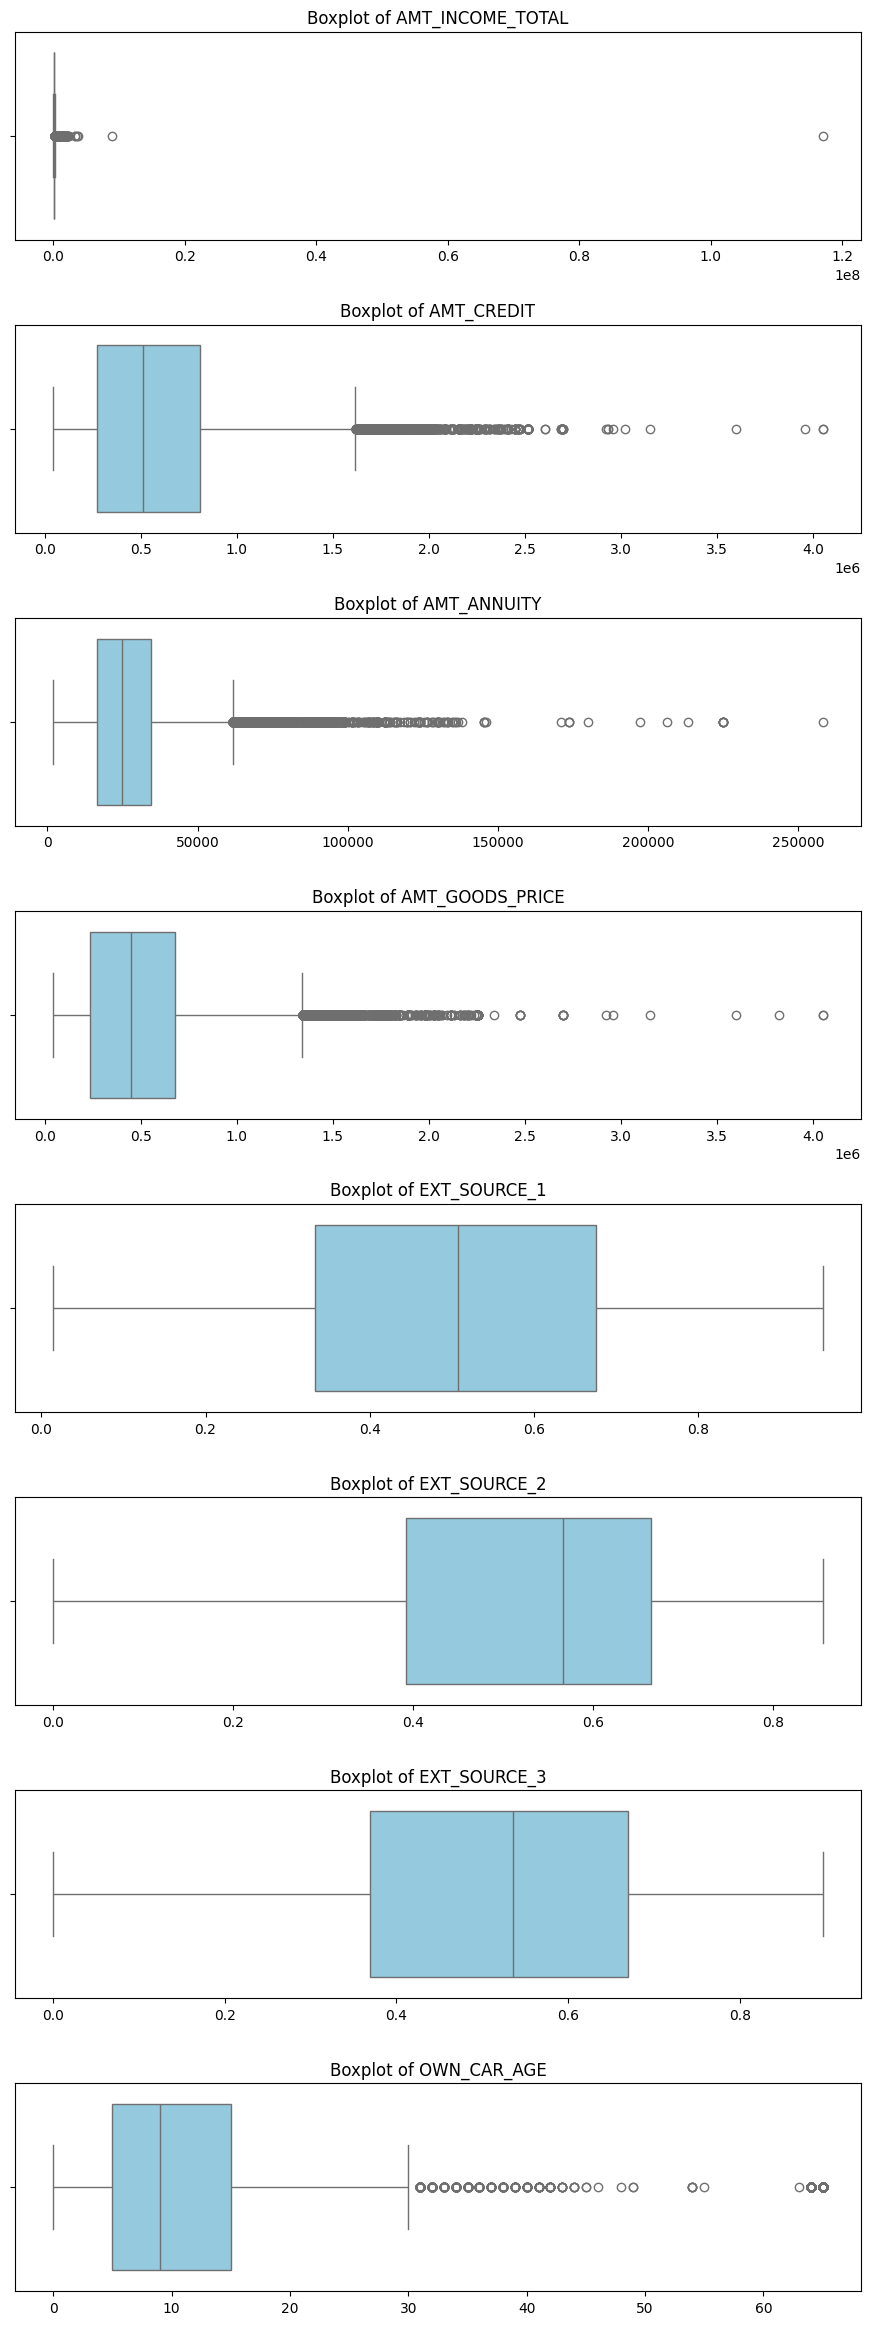

In [3]:
# List of columns to check for outliers
cols_to_check = [
    'AMT_INCOME_TOTAL',
    'AMT_CREDIT',
    'AMT_ANNUITY',
    'AMT_GOODS_PRICE',
    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',
    'OWN_CAR_AGE'

]

# Set up subplots
num_cols = len(cols_to_check)
fig, axes = plt.subplots(nrows=num_cols, ncols=1, figsize=(10, num_cols * 3))
fig.tight_layout(pad=4.0)

# Create boxplot for each column
for i, col in enumerate(cols_to_check):
    if col in df.columns:
        sns.boxplot(x=df[col], ax=axes[i], color='skyblue')
        axes[i].set_title(f'Boxplot of {col}')
        axes[i].set_xlabel('')

plt.show()

In [4]:
# 2. Binning Functions
def bin_numerical_column(df, column_name, binning_strategy, num_bins=5, bin_edges=None, labels=None):

    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in DataFrame.")

    if binning_strategy == 'equal_width':
        binned_series = pd.cut(df[column_name], bins=num_bins, labels=labels)
        print(f"{column_name}: Binned using equal width into {num_bins} bins.")
    elif binning_strategy == 'equal_frequency':
        binned_series = pd.qcut(df[column_name], q=num_bins, labels=labels)
        print(f"{column_name}: Binned using equal frequency into {num_bins} bins.")
    elif binning_strategy == 'custom':
        if bin_edges is None:
            raise ValueError("bin_edges must be provided for custom binning.")
        binned_series = pd.cut(df[column_name], bins=bin_edges, labels=labels, right=True)
        print(f"{column_name}: Binned using custom edges: {bin_edges}")
    else:
        raise ValueError(f"Invalid binning_strategy: '{binning_strategy}'.  Must be 'equal_width', 'equal_frequency', or 'custom'.")

    return binned_series

# 3. Apply Binning to Selected Columns
# Example usage:
df['INCOME_BINS'] = bin_numerical_column(df, 'AMT_INCOME_TOTAL', 'equal_width', num_bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
df['CREDIT_BINS'] = bin_numerical_column(df, 'AMT_CREDIT', 'equal_frequency', num_bins=4, labels=['Small', 'Medium', 'Large', 'Very Large'])
df['AGE_BINS'] = bin_numerical_column(df, 'DAYS_BIRTH', 'custom',
                                     bin_edges=[-15000, -11000, -7000, -3000, 0],
                                     labels=['Senior', 'Middle Aged', 'Young Adult', 'Very Young Adult'])
df['FAM_SIZE_BINS'] = bin_numerical_column(df, 'CNT_FAM_MEMBERS', 'custom',
                                     bin_edges=[0, 1, 2, 3, 4, 10],
                                     labels=['Single', 'Couple', 'Small Family', 'Medium Family', 'Large Family'])

# Print the DataFrame with the binned columns
print(df[['AMT_INCOME_TOTAL', 'INCOME_BINS', 'AMT_CREDIT', 'CREDIT_BINS', 'DAYS_BIRTH', 'AGE_BINS', 'CNT_FAM_MEMBERS', 'FAM_SIZE_BINS']].head())

# Print the value counts of the bins to see the distribution
print("\nIncome Bins Distribution:")
print(df['INCOME_BINS'].value_counts(sort=False))
print("\nCredit Bins Distribution:")
print(df['CREDIT_BINS'].value_counts(sort=False))
print("\nAge Bins Distribution:")
print(df['AGE_BINS'].value_counts(sort=False))
print("\nFamily Size Bins Distribution:")
print(df['FAM_SIZE_BINS'].value_counts(sort=False))

AMT_INCOME_TOTAL: Binned using equal width into 5 bins.
AMT_CREDIT: Binned using equal frequency into 4 bins.
DAYS_BIRTH: Binned using custom edges: [-15000, -11000, -7000, -3000, 0]
CNT_FAM_MEMBERS: Binned using custom edges: [0, 1, 2, 3, 4, 10]
   AMT_INCOME_TOTAL INCOME_BINS  AMT_CREDIT CREDIT_BINS  DAYS_BIRTH  \
0          202500.0    Very Low    406597.5      Medium     -9461.0   
1          270000.0    Very Low   1293502.5  Very Large    -16765.0   
2           67500.0    Very Low    135000.0       Small    -19046.0   
3          135000.0    Very Low    312682.5      Medium    -19005.0   
4          121500.0    Very Low    513000.0       Large    -19932.0   

      AGE_BINS  CNT_FAM_MEMBERS FAM_SIZE_BINS  
0  Middle Aged              1.0        Single  
1          NaN              2.0        Couple  
2          NaN              1.0        Single  
3          NaN              2.0        Couple  
4          NaN              1.0        Single  

Income Bins Distribution:
INCOME_BINS

In [5]:
# Display columns with missing values and their percentages
nulls = df.isnull().mean() * 100
print(nulls[nulls > 0].sort_values(ascending=False).head())
print(f"Number of columns with null values: {len(nulls)}")
# Select numeric columns (int and float)
numeric_columns = df.select_dtypes(include=['int64', 'float64'])

# Find columns with null values among them
numeric_columns_with_nulls = numeric_columns.columns[numeric_columns.isnull().any()].tolist()

print("Numeric columns (int or float) with null values:")
print(numeric_columns_with_nulls)

# Select categorical columns
categorical_columns = df.select_dtypes(include=['object', 'category'])

# Find categorical columns with null values
categorical_columns_with_nulls = categorical_columns.columns[categorical_columns.isnull().any()].tolist()

print("Categorical columns with null values:")
print(categorical_columns_with_nulls)


# Fill nulls in each categorical column with its mode
for col in categorical_columns_with_nulls:
    if df[col].isnull().any():
        mode_value = df[col].mode()[0]
        df[col]=df[col].fillna(mode_value)

int_columns_with_mode_null_values=['APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE',
 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE','NONLIVINGAPARTMENTS_MODE','TOTALAREA_MODE']

for col in int_columns_with_mode_null_values:
    if df[col].isnull().any():
        mode_value = df[col].mode()[0]
        df[col]=df[col].fillna(mode_value)

finance_columns_with_null_values=['AMT_ANNUITY', 'AMT_GOODS_PRICE','OWN_CAR_AGE',  'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG',
 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG','NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI',  'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']

for col in finance_columns_with_null_values:
    if df[col].isnull().any():
        median_value = df[col].median()
        df[col]=df[col].fillna(median_value)

null_counts = df.isnull().sum()



print("Columns with null values and their counts after filling:")
print(null_counts)




COMMONAREA_AVG              69.698174
COMMONAREA_MODE             69.698174
COMMONAREA_MEDI             69.698174
NONLIVINGAPARTMENTS_MODE    69.233083
NONLIVINGAPARTMENTS_MEDI    69.233083
dtype: float64
Number of columns with null values: 126
Numeric columns (int or float) with null values:
['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG',

In [7]:

#Check is there any duplicates

dups=df.duplicated().sum()
print("\nDuplicated Records:\n")
print(dups)

# Find duplicates ignoring the unique ID
duplicates_subset = df[df.duplicated(subset=df.columns.difference(['SK_ID_CURR']))]
print(f"Number of duplicate rows (excluding ID): {duplicates_subset.shape[0]}")








Duplicated Records:

0
Number of duplicate rows (excluding ID): 0


3)	Print the percentage of default to a payer of the dataset for the TARGET column

In [8]:
# Class distribution
target_counts = df['TARGET'].value_counts(normalize=True) * 100
print("Percentage of Non-Default (0): {:.2f}%".format(target_counts[0]))
print("Percentage of Default (1): {:.2f}%".format(target_counts[1]))

Percentage of Non-Default (0): 91.91%
Percentage of Default (1): 8.09%


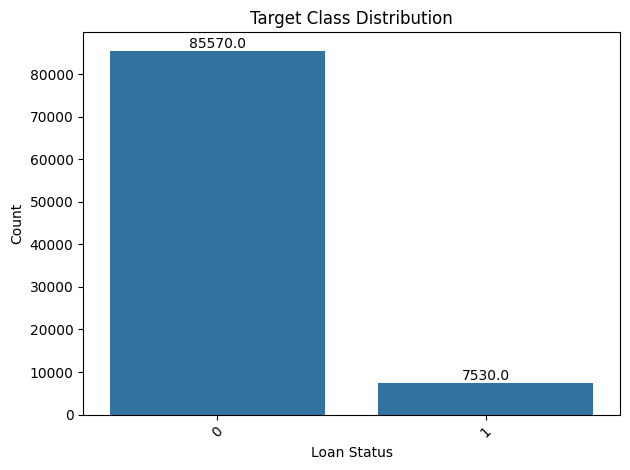

In [9]:
ax = sns.countplot(x='TARGET', data=df)
plt.title('Target Class Distribution')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Add class labels (counts) on top of bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

4)	Balance the dataset if the data is imbalanced


In [10]:
def handle_outliers(df, column_name, method='clip', iqr_factor=1.5, percentile_lower=1, percentile_upper=99):

    df_original = df.copy() # Create a copy to compare later
    print(f"\nHandling outliers in column: {column_name}, method: {method}")

    if column_name not in df.columns:
        print(f"Error: Column '{column_name}' not found in DataFrame.")
        return df # Return original df

    if method == 'none':
        print("No outlier handling performed.")
        return df  # Return original DataFrame

    # 1. Calculate bounds for outlier detection
    if method in ['clip', 'winsorize']:
        lower_bound = np.percentile(df[column_name], percentile_lower)
        upper_bound = np.percentile(df[column_name], percentile_upper)
        print(f"Lower bound ({percentile_lower}th percentile): {lower_bound:.2f}, Upper bound ({percentile_upper}th percentile): {upper_bound:.2f}")
    elif method == 'iqr':
        Q1 = df[column_name].quantile(0.25)
        Q3 = df[column_name].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_factor * IQR
        upper_bound = Q3 + iqr_factor * IQR
        print(f"Lower bound (IQR): {lower_bound:.2f}, Upper bound (IQR): {upper_bound:.2f}, IQR factor: {iqr_factor}")
    elif method == 'zscore':
        mean = df[column_name].mean()
        std = df[column_name].std()
        lower_bound = mean - 3 * std
        upper_bound = mean + 3 * std
        print(f"Lower bound (Z-score): {lower_bound:.2f}, Upper bound (Z-score): {upper_bound:.2f}")

    # 2. Handle outliers based on the selected method
    if method == 'clip':
        df[column_name] = np.clip(df[column_name], lower_bound, upper_bound)
        print("Outliers clipped to bounds.")
    elif method == 'zscore':
        z_scores = np.abs((df[column_name] - df[column_name].mean()) / df[column_name].std())
        df = df[z_scores <= 3] # Keep only those within 3 standard deviations
        print("Outliers removed based on Z-score.")
    elif method == 'iqr':
        df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
        print("Outliers removed based on IQR.")
    elif method == 'winsorize':
        df[column_name] = np.where(df[column_name] < lower_bound, lower_bound, df[column_name])
        df[column_name] = np.where(df[column_name] > upper_bound, upper_bound, df[column_name])
        print("Outliers winsorized to bounds.")


    # 3. Visualize the original and handled data
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.boxplot(data=df_original, x=column_name)
    plt.title(f'Original Distribution of {column_name}')

    plt.subplot(1, 2, 2)
    sns.boxplot(data=df, x=column_name)
    plt.title(f'Distribution of {column_name} after handling outliers ({method})')
    plt.show()
    return df

def plot_outliers(df, column_name):
    """
    Plots the distribution of a column using a boxplot and histogram,
    to visualize outliers.

    Args:
        df (pd.DataFrame): The input DataFrame.
        column_name (str): The name of the column to plot.
    """
    if column_name not in df.columns:
        print(f"Error: Column '{column_name}' not found in DataFrame.")
        return

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.boxplot(data=df, x=column_name)
    plt.title(f'Box Plot of {column_name}')

    plt.subplot(1, 2, 2)
    sns.histplot(df[column_name], kde=True)
    plt.title(f'Histogram of {column_name}')
    plt.show()

5)	Plot the balanced or imbalanced data


Handling outliers in column: AMT_GOODS_PRICE, method: iqr
Lower bound (IQR): -423000.00, Upper bound (IQR): 1341000.00, IQR factor: 1.5
Outliers removed based on IQR.


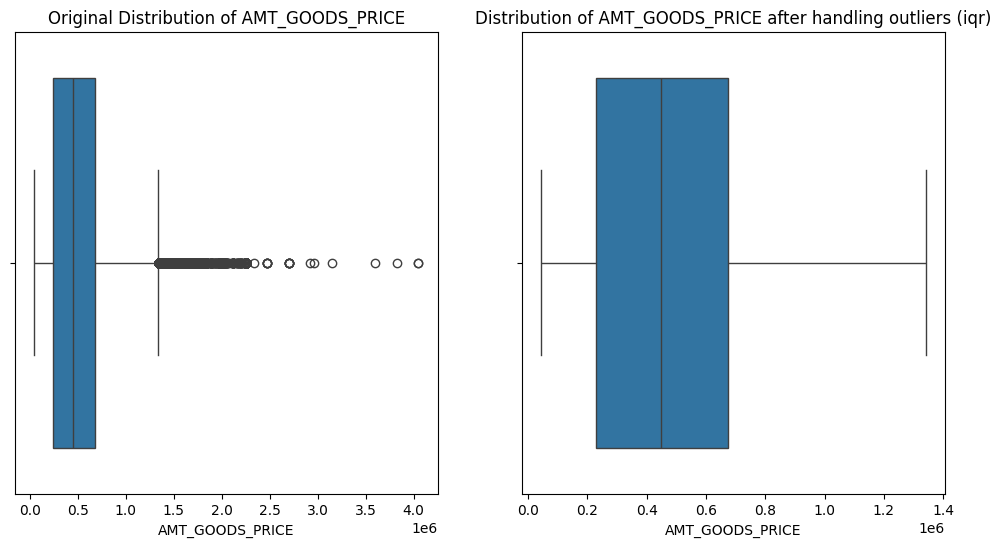


Handling outliers in column: AMT_CREDIT, method: iqr
Lower bound (IQR): -471254.62, Upper bound (IQR): 1505424.38, IQR factor: 1.5
Outliers removed based on IQR.


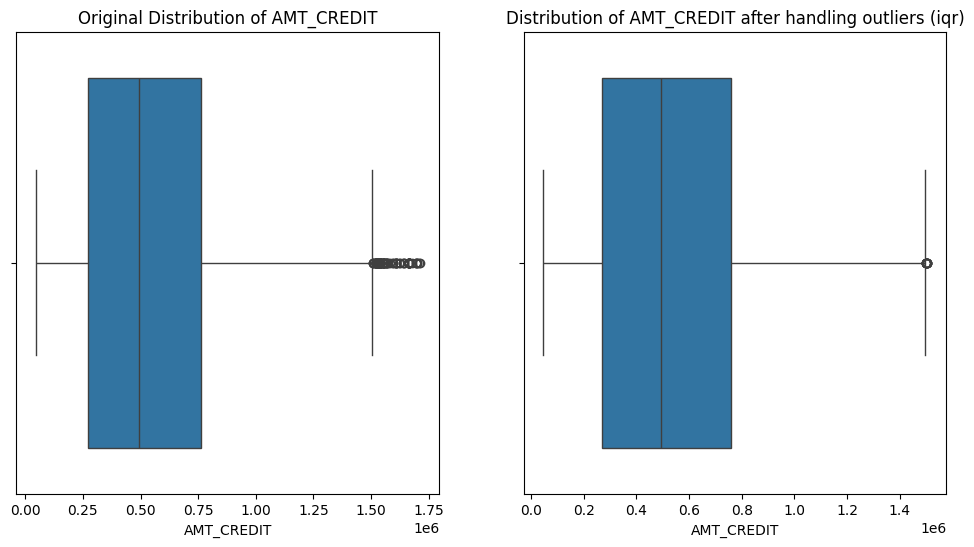


Handling outliers in column: AMT_ANNUITY, method: iqr
Lower bound (IQR): -8457.75, Upper bound (IQR): 57116.25, IQR factor: 1.5
Outliers removed based on IQR.


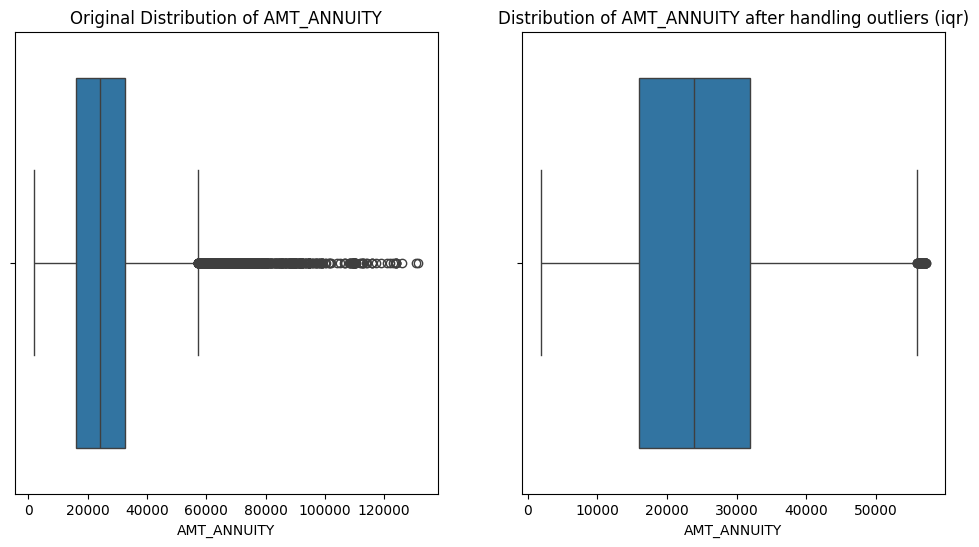


Handling outliers in column: AMT_INCOME_TOTAL, method: iqr
Lower bound (IQR): -22500.00, Upper bound (IQR): 337500.00, IQR factor: 1.5
Outliers removed based on IQR.


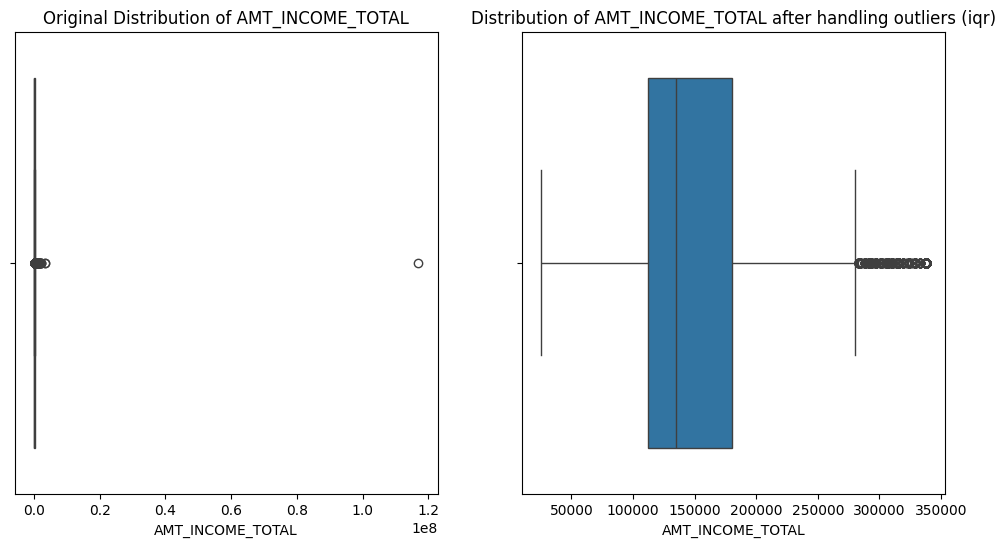

In [11]:

# Handling outliers through iqr method

df = handle_outliers(df.copy(), 'AMT_GOODS_PRICE', method='iqr')


df = handle_outliers(df.copy(), 'AMT_CREDIT', method='iqr')


df = handle_outliers(df.copy(), 'AMT_ANNUITY', method='iqr')


df = handle_outliers(df.copy(), 'AMT_INCOME_TOTAL', method='iqr')


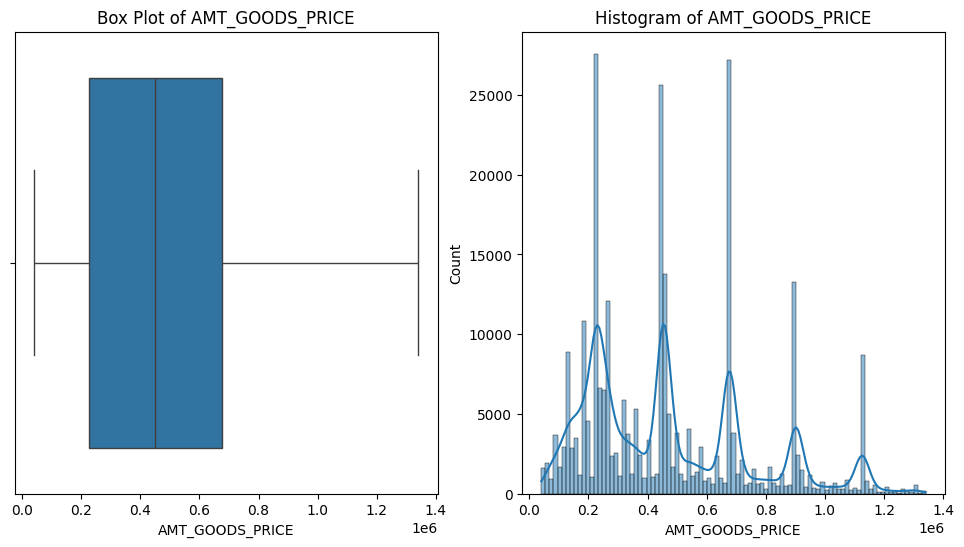

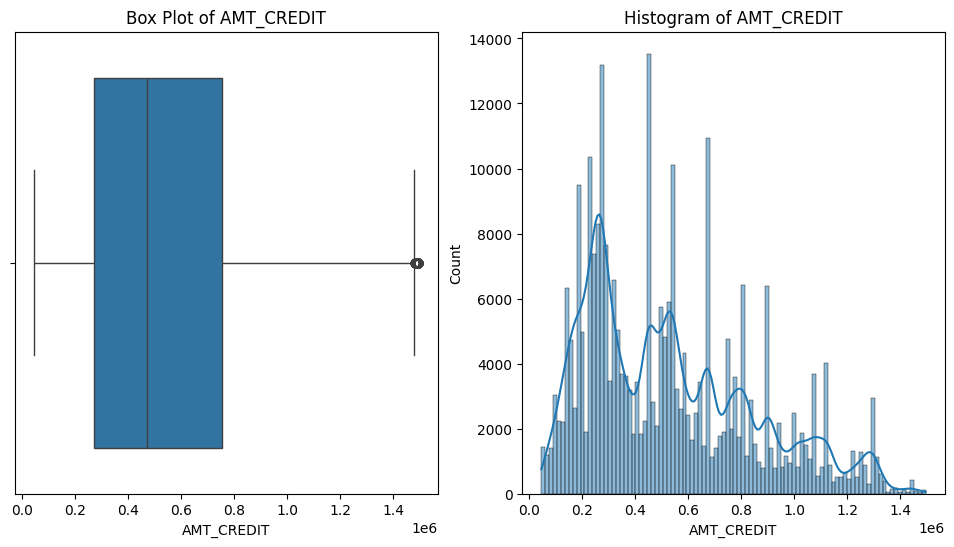

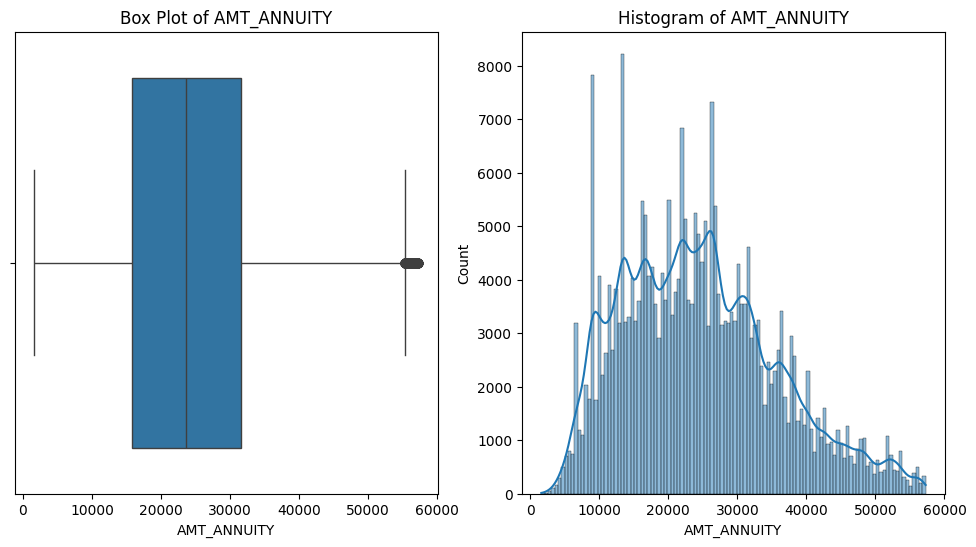

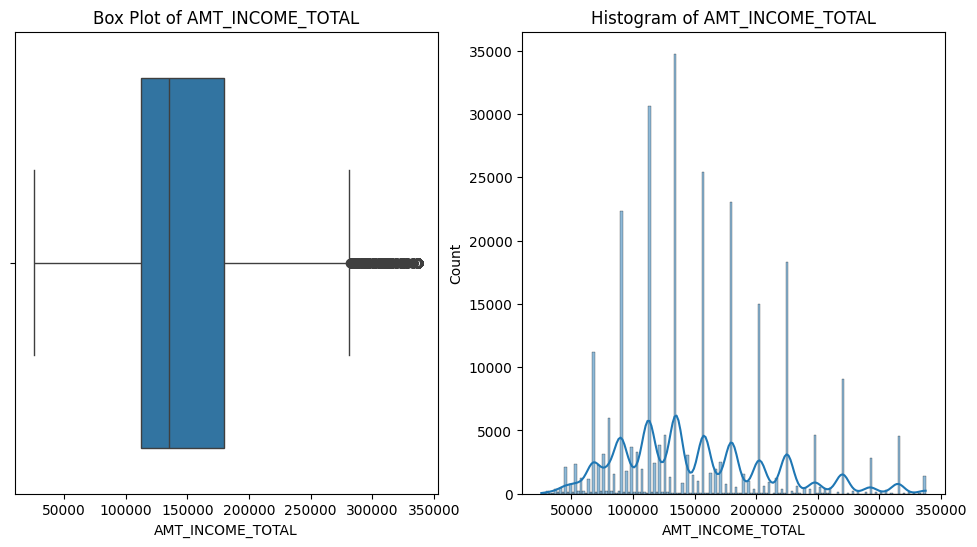

In [ ]:
#Plot the box plot and histogram  for outlier columns
plot_outliers(df, 'AMT_GOODS_PRICE')


plot_outliers(df, 'AMT_CREDIT')


plot_outliers(df, 'AMT_ANNUITY')

plot_outliers(df, 'AMT_INCOME_TOTAL')


6)	Encode the columns that is required for the model

In [12]:



# List of columns to drop
columns_to_drop = [
    'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_WORK_PHONE',
    'FLAG_PHONE', 'FLAG_EMAIL',
    'HOUR_APPR_PROCESS_START', 'WEEKDAY_APPR_PROCESS_START',
    'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
    'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY'
]



# Drop columns if they exist in the DataFrame
df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)


#  Find categorical columns
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
print("\nCategorical Columns:")
print(categorical_columns)

# Basic encoding for non-numeric features
df=pd.get_dummies(df,columns=categorical_columns,dtype=int,drop_first=True)

X = df.drop(columns=['SK_ID_CURR', 'TARGET'])
y = df['TARGET']














Categorical Columns:
Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE',
       'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 'INCOME_BINS',
       'CREDIT_BINS', 'AGE_BINS', 'FAM_SIZE_BINS'],
      dtype='object')


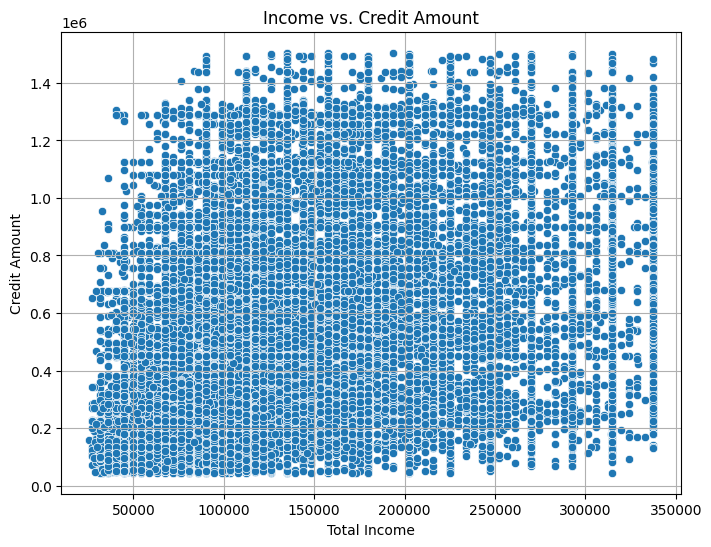

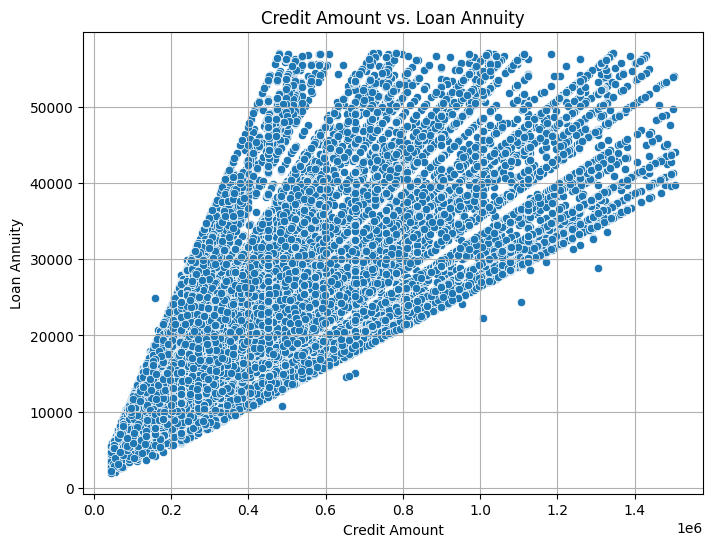

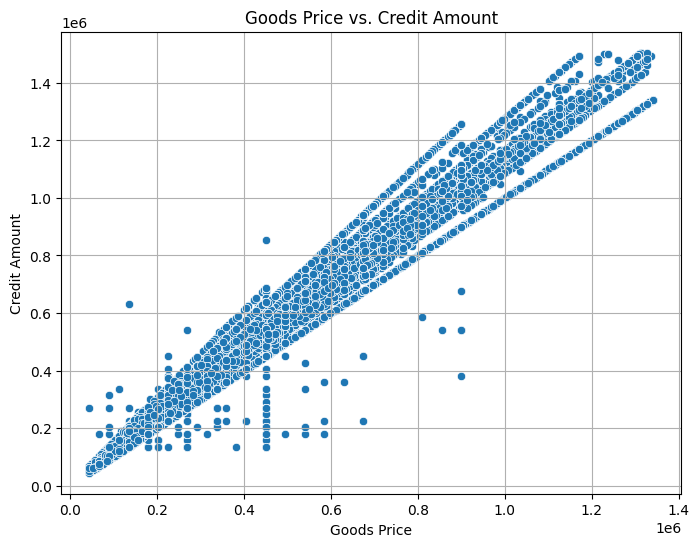

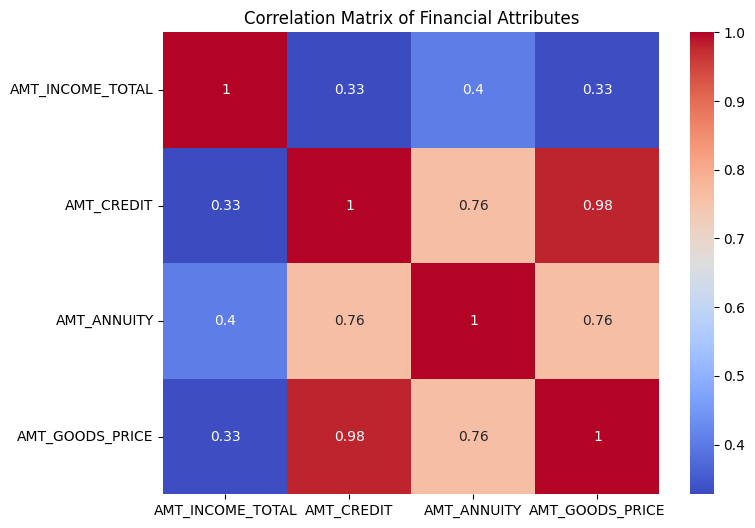

In [13]:
# 1. Scatter Plot: Income vs. Credit
plt.figure(figsize=(8, 6))
sns.scatterplot(x='AMT_INCOME_TOTAL', y='AMT_CREDIT', data=df)
plt.title('Income vs. Credit Amount')
plt.xlabel('Total Income')
plt.ylabel('Credit Amount')
plt.grid(True)
plt.show()

# 2. Scatter Plot: Credit vs. Annuity
plt.figure(figsize=(8, 6))
sns.scatterplot(x='AMT_CREDIT', y='AMT_ANNUITY', data=df)
plt.title('Credit Amount vs. Loan Annuity')
plt.xlabel('Credit Amount')
plt.ylabel('Loan Annuity')
plt.grid(True)
plt.show()

# 3. Scatter Plot: Goods Price vs. Credit Amount
plt.figure(figsize=(8, 6))
sns.scatterplot(x='AMT_GOODS_PRICE', y='AMT_CREDIT', data=df)
plt.title('Goods Price vs. Credit Amount')
plt.xlabel('Goods Price')
plt.ylabel('Credit Amount')
plt.grid(True)
plt.show()

# 4. Correlation Matrix Heatmap
plt.figure(figsize=(8, 6))
corr_matrix = df[['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Financial Attributes')
plt.show()


In [14]:


# Assuming X and y are your features and target variable
#rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
#X_bal, y_bal= rus.fit_resample(X, y)
# Balance the data - Experiment with different strategies
smote = SMOTE(sampling_strategy=0.3, random_state=42)
X_bal, y_bal = smote.fit_resample(X, y)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal) # Consider stratify



In [36]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



# Build the model
model = Sequential()
model.add(Input(shape=(X_train_scaled.shape[1],)))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(64)) # Removed activation here
model.add(LeakyReLU(negative_slope=0.1)) # Added LeakyReLU
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

In [37]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Compile the model with more metrics
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=64, validation_split=0.1, verbose=1, callbacks=[early_stop,reduce_lr])

Epoch 1/50
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - AUC: 0.8348 - Precision: 0.6628 - Recall: 0.6577 - accuracy: 0.8288 - loss: 0.9301 - val_AUC: 0.9031 - val_Precision: 0.9803 - val_Recall: 0.6552 - val_accuracy: 0.9152 - val_loss: 0.3169 - learning_rate: 0.0010
Epoch 2/50
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.8965 - Precision: 0.9485 - Recall: 0.6508 - accuracy: 0.9117 - loss: 0.3085 - val_AUC: 0.9106 - val_Precision: 0.9718 - val_Recall: 0.6726 - val_accuracy: 0.9178 - val_loss: 0.2834 - learning_rate: 0.0010
Epoch 3/50
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - AUC: 0.8977 - Precision: 0.9536 - Recall: 0.6514 - accuracy: 0.9130 - loss: 0.2950 - val_AUC: 0.9092 - val_Precision: 0.9735 - val_Recall: 0.6574 - val_accuracy: 0.9146 - val_loss: 0.2869 - learning_rate: 0.0010
Epoch 4/50
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - AUC: 0.8982 - Precision: 0.9596 - Recall: 0.6467 - accuracy: 0.9138 - loss: 0.2913 - val_AUC: 0.9036 - val_Precision: 0.9648 - val_Recall:

7)	Calculate Sensitivity as a metric

In [38]:
# Evaluate the model
y_pred_probs = model.predict(X_test_scaled)
y_pred = (y_pred_probs > 0.5).astype(int)



print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nAUC Score:", roc_auc_score(y_test, y_pred_probs))



626/626 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Confusion Matrix:
[[15355    44]
 [ 1441  3178]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     15399
           1       0.99      0.69      0.81      4619

    accuracy                           0.93     20018
   macro avg       0.95      0.84      0.88     20018
weighted avg       0.93      0.93      0.92     20018


AUC Score: 0.9106331585596391


Sensitivity (Recall): 0.6880


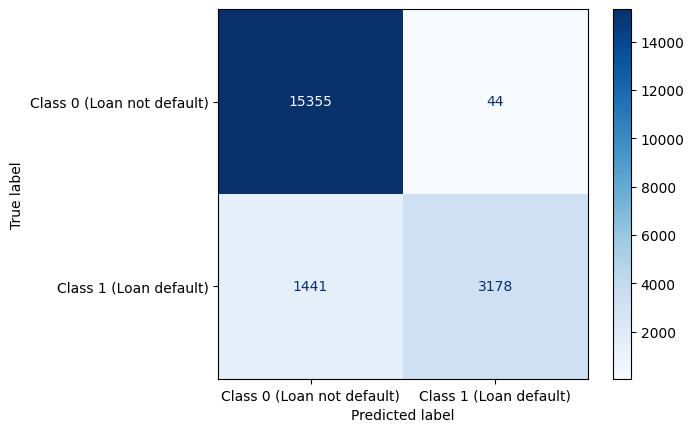

In [39]:


# Define labels
labels = ['Class 0 (Loan not default)', 'Class 1 (Loan default)']


# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Sensitivity / Recall
sensitivity = recall_score(y_test, y_pred)


print(f"Sensitivity (Recall): {sensitivity:.4f}")


# Step 3: Display confusion matrix with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')






8)	Calculate the area under  the receiver operating characteristics curve

ROC AUC Score: 0.9106


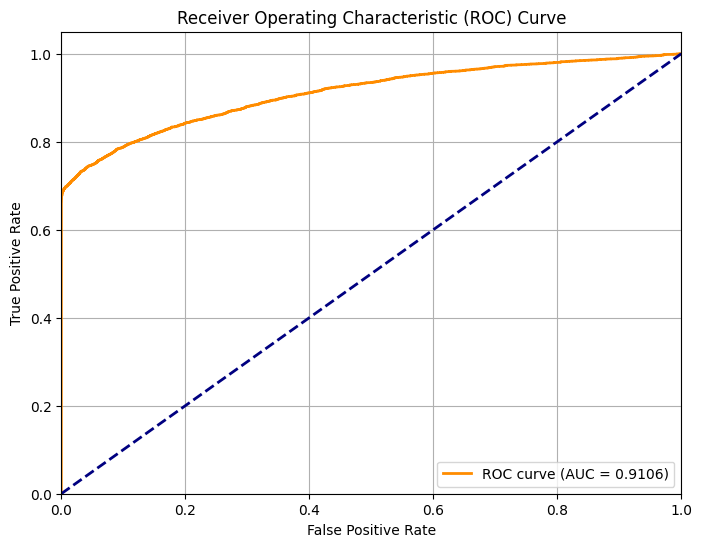

In [41]:

roc_auc = roc_auc_score(y_test, y_pred_probs)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Compute false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# Compute AUC
auc_score = roc_auc_score(y_test, y_pred_probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
